**Dataset Loading and Shuffling**

The dataset is loaded from a CSV file (*adware_merged.csv*) into a Pandas DataFrame. To ensure randomness and prevent bias in the analysis, the data is shuffled using a fixed random seed of 42. The *adwaredf.columns.str.strip()* function is used to strip any leading or trailing whitespace from column names for consistency.

In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import mutual_info_score
from imblearn.combine import SMOTETomek
from collections import Counter
import joblib
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

In [ ]:
# Load and shuffle the dataset
url = "adware_dataset.csv"
adwaredf = pd.read_csv(url)
adwaredf = adwaredf.sample(frac=1, random_state=42)
adwaredf.columns = adwaredf.columns.str.strip()
adwaredf.shape[1]



85

**Handling Missing and Zero Values**

Initially, the script identifies columns with numeric data types. It calculates the ratio of non-zero values for each numeric column, considering columns with a ratio above 50% as viable for imputation. For these columns, zero values are replaced with the mean of non-zero values, ensuring no data distortions from zero inflation. Columns with a non-zero ratio of 50% or lower are deemed irrelevant and removed from the dataset to improve data quality and focus.

Additionally, specific columns, such as *Source IP* and *Destination IP*, which are irrelevant to the model’s goals, are dropped. The remaining columns are then analyzed for rows with high-zero counts, which are also excluded to improve data representativeness.



In [ ]:
import pandas as pd

# Ensure all columns are numeric
numeric_columns = adwaredf.select_dtypes(include=['number']).columns

# Calculate the non-zero ratio for numeric columns only
non_zero_ratio = (adwaredf[numeric_columns] != 0).mean()
columns_to_impute = non_zero_ratio[non_zero_ratio > 0.5].index

# Impute zeros with the mean of non-zero values for numeric columns
for column in columns_to_impute:
    # Check if column is numeric and calculate the mean of non-zero values
    if pd.api.types.is_numeric_dtype(adwaredf[column]):
        mean_value = adwaredf.loc[adwaredf[column] != 0, column].mean()
        # Replace zeros with the mean value
        adwaredf[column] = adwaredf[column].replace(0, mean_value)

# Drop columns with non-zero ratio <= 50% (optional)
columns_with_low_non_zero = non_zero_ratio[non_zero_ratio <= 0.5].index
adwaredf = adwaredf.drop(columns=columns_with_low_non_zero)

# Save the updated DataFrame
print("\nDataFrame after imputing zeros and dropping unsuitable columns:")
print(adwaredf)
adwaredf.to_csv('filtered.csv', index=False)



DataFrame after imputing zeros and dropping unsuitable columns:
                                       Flow ID            Timestamp  \
12461        10.42.0.151-10.42.0.1-36160-53-17  15/06/2017 04:27:30   
4744       172.217.2.99-10.42.0.151-80-52438-6  13/06/2017 05:40:49   
18481        10.42.0.211-10.42.0.1-60127-53-17  14/06/2017 12:52:43   
24304    172.217.10.99-10.42.0.151-443-60822-6  14/06/2017 08:25:33   
7191      10.42.0.151-125.39.133.40-42680-80-6  13/06/2017 12:23:25   
...                                        ...                  ...   
21575   10.42.0.151-103.235.46.211-46820-443-6  14/06/2017 01:59:06   
5390      10.42.0.151-52.84.89.242-58394-443-6  13/06/2017 05:32:39   
860    180.149.139.248-10.42.0.211-443-55410-6  14/06/2017 04:56:59   
15795    203.205.158.66-10.42.0.211-80-43283-6  14/06/2017 12:52:44   
23654        10.42.0.151-10.42.0.1-54765-53-17  14/06/2017 02:06:29   

       Flow Duration  Total Fwd Packets  Flow Packets/s  Flow IAT Mean  \
12461   

**Dropping Zero and Irrelevant Columns**

In [ ]:
#columns with many zeros
columns_with_zero = adwaredf.columns[(adwaredf == 0).any()]
irrelevant_columns = ['Source IP', 'Destination IP']
# Drop these columns
adwaredf = adwaredf.drop(columns=columns_with_zero)
adwaredf = adwaredf.drop(columns=irrelevant_columns)
print("\nDataFrame after dropping columns with at least one zero:")
print(adwaredf)
# adwaredf.to_csv('filtered.csv', index=False)


DataFrame after dropping columns with at least one zero:
                                       Flow ID            Timestamp  \
12461        10.42.0.151-10.42.0.1-36160-53-17  15/06/2017 04:27:30   
4744       172.217.2.99-10.42.0.151-80-52438-6  13/06/2017 05:40:49   
18481        10.42.0.211-10.42.0.1-60127-53-17  14/06/2017 12:52:43   
24304    172.217.10.99-10.42.0.151-443-60822-6  14/06/2017 08:25:33   
7191      10.42.0.151-125.39.133.40-42680-80-6  13/06/2017 12:23:25   
...                                        ...                  ...   
21575   10.42.0.151-103.235.46.211-46820-443-6  14/06/2017 01:59:06   
5390      10.42.0.151-52.84.89.242-58394-443-6  13/06/2017 05:32:39   
860    180.149.139.248-10.42.0.211-443-55410-6  14/06/2017 04:56:59   
15795    203.205.158.66-10.42.0.211-80-43283-6  14/06/2017 12:52:44   
23654        10.42.0.151-10.42.0.1-54765-53-17  14/06/2017 02:06:29   

       Flow Duration  Total Fwd Packets  Flow Packets/s  Flow IAT Mean  \
12461          

**Data Visualization**

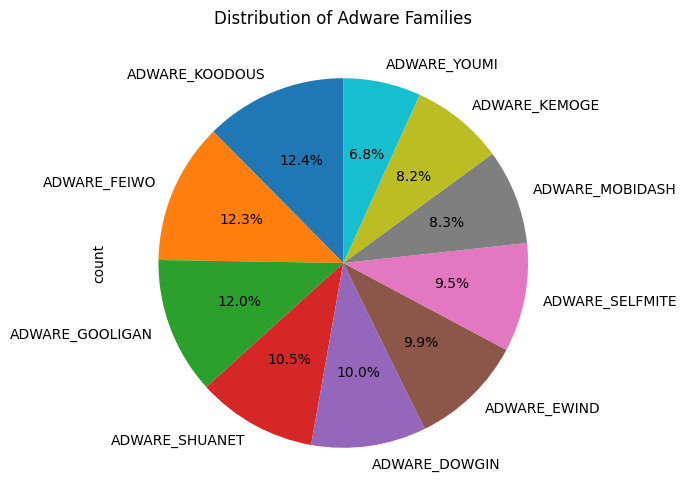

Label
ADWARE_KOODOUS     3604
ADWARE_FEIWO       3578
ADWARE_GOOLIGAN    3475
ADWARE_SHUANET     3050
ADWARE_DOWGIN      2917
ADWARE_EWIND       2888
ADWARE_SELFMITE    2763
ADWARE_MOBIDASH    2420
ADWARE_KEMOGE      2367
ADWARE_YOUMI       1970
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
adwaredf['Label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Adware Families')
plt.show()
print(adwaredf['Label'].value_counts())


**Excluding Rows and Encoding**

In [ ]:
excluded_rows = adwaredf.groupby('Label').first().reset_index()

# Exclude these rows from the original DataFrame
adwaredf = adwaredf[~adwaredf.index.isin(excluded_rows.index)]

# Save the excluded rows to a CSV file
excluded_rows.to_csv('excluded_rows.csv', index=False)

In [ ]:
# Save the 'Label' column
label_column = adwaredf['Label']

# Encoding
label_encoder = LabelEncoder()
for col in adwaredf.select_dtypes(include=['object']).columns:
    adwaredf[col] = label_encoder.fit_transform(adwaredf[col])
constant_columns = [col for col in adwaredf.columns if adwaredf[col].nunique() <= 1]
print("Constant Columns:", constant_columns)
constant_rows = adwaredf[adwaredf.nunique(axis=1) <= 1].index
print("Constant Rows:", constant_rows)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

Constant Columns: []
Constant Rows: Index([], dtype='int64')
{'ADWARE_DOWGIN': 0, 'ADWARE_EWIND': 1, 'ADWARE_FEIWO': 2, 'ADWARE_GOOLIGAN': 3, 'ADWARE_KEMOGE': 4, 'ADWARE_KOODOUS': 5, 'ADWARE_MOBIDASH': 6, 'ADWARE_SELFMITE': 7, 'ADWARE_SHUANET': 8, 'ADWARE_YOUMI': 9}


**Normalization and Train-Test Split**
The selected features are normalized using StandardScaler to ensure all features are on a similar scale, improving the performance of machine learning algorithms. The target variable (Label) is encoded again to align with model requirements. The dataset is split into training and testing subsets, maintaining stratification to preserve the proportion of classes across both sets. A 90-10 split ratio is used, emphasizing more data for training.

Selection with Information Gain

Data Preprocessing and Splitting

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

features = adwaredf.drop(columns=['Label'])  # Drop 'Label' from features
label_column = adwaredf['Label']

# Function to compute Information Gain (IG) using mutual_info_classif
def information_gain(feature, target):
    # Reshape feature to 2D as mutual_info_classif expects this format
    feature = feature.values.reshape(-1, 1)
    return mutual_info_classif(feature, target, discrete_features=True)[0]

# Compute IG for each feature
metrics = {
    'Feature': [],
    'Information Gain': []
}

for feature in features.columns:
    ig = information_gain(features[feature], label_column)
    metrics['Feature'].append(feature)
    metrics['Information Gain'].append(ig)

# Create a DataFrame for ranking features
metrics_df = pd.DataFrame(metrics).sort_values(by='Information Gain', ascending=False)

# Select the top features based on Information Gain
top_features = metrics_df.head(8)['Feature'].tolist()  # Top 8 features
X_top_features = adwaredf[top_features]

# Print the metrics DataFrame and selected features
print("Feature Metrics:")
print(metrics_df)
print("Selected Top Features:", X_top_features.columns.tolist())

# Normalize the selected features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_top_features)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(label_column)

# Split the normalized data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded
)

print("Data split into training and testing sets.")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/loc

Feature Metrics:
                        Feature  Information Gain
0                       Flow ID          2.253156
4                     Timestamp          2.252172
25                Fwd Packets/s          2.152954
15               Flow Packets/s          2.145942
5                 Flow Duration          2.134282
16                Flow IAT Mean          2.053129
1                   Source Port          1.849569
17                 Flow IAT Max          1.717558
26                Bwd Packets/s          1.547072
20                 Fwd IAT Mean          1.419689
18                 Flow IAT Min          1.391248
14                 Flow Bytes/s          1.353162
19                Fwd IAT Total          1.263141
21                  Fwd IAT Max          1.255806
22                  Fwd IAT Min          0.963646
28           Packet Length Mean          0.734581
30       Packet Length Variance          0.732255
29            Packet Length Std          0.732255
32          Average Packet Size  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/loc

**Model Building and Evaluation**
Three machine learning models are trained on the processed data:

1. **XGBoost Classifier:**
An advanced gradient-boosting algorithm is trained using the training data. The model is evaluated on the test data, generating predictions that are compared against actual labels. Metrics such as confusion matrix, accuracy, precision, and recall are computed to assess performance. A classification report provides detailed metrics for each class, and the trained model is saved for future use.

2. **Logistic Regression:**
A simpler linear model, logistic regression is trained with increased iteration limits to ensure convergence. Similar evaluation metrics are computed for comparison with other models. The trained model is also saved.

3. **Random Forest Classifier:**
A robust ensemble model using decision trees, the Random Forest classifier is trained and evaluated in the same manner as other models. Its results are compared with those of the XGBoost and logistic regression models.





**Model Training and Evaluation (XGBoost)**

In [ ]:
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

print("XGBoost model training completed.")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:41:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost model training completed.


In [ ]:
model_filename = 'model.joblib'
joblib.dump(xgb_clf, model_filename)
print(f"Model saved to {model_filename}")

Model saved to model.joblib


In [ ]:
# Make predictions
y_pred = xgb_clf.predict(X_test)

# Compute and print confusion matrix directly (for multi-class)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Compute additional metrics
accuracy = accuracy_score(y_test, y_pred)
# Specify 'average' for multiclass precision
precision = precision_score(y_test, y_pred, average='weighted')  # or 'micro', 'macro'
recall = recall_score(y_test, y_pred, average='weighted')  # or 'micro', 'macro'

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# full classification report
classification_rep = classification_report(y_test, y_pred)
print("\nClassification Report:\n", classification_rep)

Confusion Matrix:
 [[290   0   0   0   0   0   0   1   0   0]
 [  0 288   0   0   0   0   1   0   0   0]
 [  0   0 352   0   6   0   0   0   0   0]
 [  0   0   0 348   0   0   0   0   0   0]
 [  0   0  13   0 215   0   9   0   0   0]
 [  0   0   0   0   0 360   0   0   0   0]
 [  0   1   1   0   5   0 235   0   0   0]
 [  0   0   0   0   0   0   0 276   0   0]
 [  0   0   0   0   0   0   2   0 303   0]
 [  0   0   0   0   0   0   0   0   0 197]]
Accuracy: 0.99
Precision: 0.99
Recall: 0.99

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       289
           2       0.96      0.98      0.97       358
           3       1.00      1.00      1.00       348
           4       0.95      0.91      0.93       237
           5       1.00      1.00      1.00       360
           6       0.95      0.97      0.96       242
           7       1.00      1.00      1.00     

**Logistic Regression Training and Evaluation**

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter
logreg_clf.fit(X_train, y_train)

print("Logistic Regression model training completed.")

# ... rest of your code for predictions and evaluation ...
# Make predictions
y_pred = logreg_clf.predict(X_test)

# Compute and print confusion matrix directly (for multi-class)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Compute additional metrics
accuracy = accuracy_score(y_test, y_pred)
# Specify 'average' for multiclass precision
precision = precision_score(y_test, y_pred, average='weighted')  # or 'micro', 'macro'
recall = recall_score(y_test, y_pred, average='weighted')  # or 'micro', 'macro'

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# full classification report
classification_rep = classification_report(y_test, y_pred)
print("\nClassification Report:\n", classification_rep)

model_filename = 'logreg_model.joblib'
joblib.dump(logreg_clf, model_filename)
print(f"Model saved to {model_filename}")

Logistic Regression model training completed.
Confusion Matrix:
 [[ 34   0   0   0   0 233   2   2  20   0]
 [  0 289   0   0   0   0   0   0   0   0]
 [  1   0 254   0 101   0   0   2   0   0]
 [  0   0   0 341   0   5   0   0   0   2]
 [  0   1 116   0 119   0   0   1   0   0]
 [ 45   0   1  72   3 101   0  75  63   0]
 [  2  15  16   0  21 127   0   0  61   0]
 [ 56   0   0   0   0  29   0 191   0   0]
 [  4   0   0   0   0 108   0   0 193   0]
 [  0   0   0   5   0   0   0   0   0 192]]
Accuracy: 0.59
Precision: 0.55
Recall: 0.59

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.12      0.16       291
           1       0.95      1.00      0.97       289
           2       0.66      0.71      0.68       358
           3       0.82      0.98      0.89       348
           4       0.49      0.50      0.49       237
           5       0.17      0.28      0.21       360
           6       0.00      0.00      0.00       242
  

**Random Forest Training and Evaluation**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# ... (Your existing code up to the point where you define X_train, y_train) ...

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

print("Random Forest model training completed.")



y_pred = rf_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Compute additional metrics
accuracy = accuracy_score(y_test, y_pred)
# Specify 'average' for multiclass precision
precision = precision_score(y_test, y_pred, average='weighted')  # or 'micro', 'macro'
recall = recall_score(y_test, y_pred, average='weighted')  # or 'micro', 'macro'

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# full classification report
classification_rep = classification_report(y_test, y_pred)
print("\nClassification Report:\n", classification_rep)
model_filename = 'rf_model.joblib'
joblib.dump(rf_clf, model_filename)
print(f"Model saved to {model_filename}")

Random Forest model training completed.
Confusion Matrix:
 [[291   0   0   0   0   0   0   0   0   0]
 [  0 289   0   0   0   0   0   0   0   0]
 [  0   0 345   0  13   0   0   0   0   0]
 [  0   0   0 348   0   0   0   0   0   0]
 [  0   0  26   0 206   0   5   0   0   0]
 [  1   0   0   0   0 357   0   2   0   0]
 [  2   0   1   0   5   2 232   0   0   0]
 [  1   0   0   0   0   0   0 275   0   0]
 [  0   0   0   0   0   0   1   0 304   0]
 [  0   0   0   0   0   0   0   0   0 197]]
Accuracy: 0.98
Precision: 0.98
Recall: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       291
           1       1.00      1.00      1.00       289
           2       0.93      0.96      0.95       358
           3       1.00      1.00      1.00       348
           4       0.92      0.87      0.89       237
           5       0.99      0.99      0.99       360
           6       0.97      0.96      0.97       242
        